# Import Libraries

In [ ]:

import os
import cv2     # for capturing videos
import math 
import sys
import geocoder
import requests
import pandas as pd
from twilio.rest import Client
from geopy.geocoders import Nominatim
import numpy as np    # for mathematical operations       
from tensorflow.keras.preprocessing import image  # for preprocessing the images
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt         # import pyplot directly
from skimage.transform import resize    # for resizing images


In [2]:
"""count = 0
videoFile = "C:\\Users\\DELL\\Desktop\\Car Accident Detection\\data\\Accidents.mp4"
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="C:\\Users\\DELL\\Desktop\\Car Accident Detection\\images\\%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")"""

'count = 0\nvideoFile = "C:\\Users\\DELL\\Desktop\\Car Accident Detection\\data\\Accidents.mp4"\ncap = cv2.VideoCapture(videoFile)   # capturing the video from the given path\nframeRate = cap.get(5) #frame rate\nx=1\nwhile(cap.isOpened()):\n    frameId = cap.get(1) #current frame number\n    ret, frame = cap.read()\n    if (ret != True):\n        break\n    if (frameId % math.floor(frameRate) == 0):\n        filename ="C:\\Users\\DELL\\Desktop\\Car Accident Detection\\images\\%d.jpg" % count;count+=1\n        cv2.imwrite(filename, frame)\ncap.release()\nprint ("Done!")'

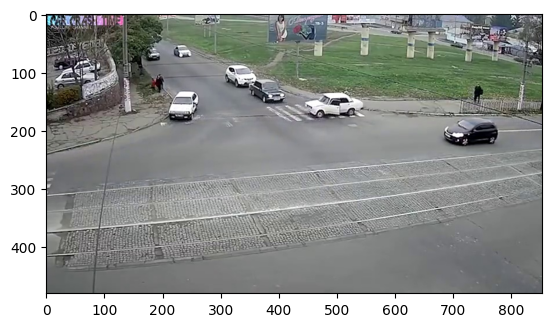

In [3]:
img = plt.imread('C:\\Users\\DELL\\Desktop\\Car Accident Detection\\images\\130.jpg')   # reading image using its name
plt.imshow(img)

In [4]:
data = pd.read_csv('C:\\Users\\DELL\\Desktop\\Car Accident Detection\\data\\mapping.csv')     # reading the csv file

In [5]:
data

,Image_ID,Class
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1
...,...,...
217,217.jpg,1
218,218.jpg,1
219,219.jpg,1
220,220.jpg,1


In [6]:
X = [ ]     # creating an empty array
for img_name in data.Image_ID:
    img = plt.imread('C:\\Users\\DELL\\Desktop\\Car Accident Detection\\images\\' + img_name)
    X.append(img)  # storing each image in array X
X = np.array(X)    # converting list to array

In [7]:
y = data.Class
dummy_y = to_categorical(y)

In [8]:
image = []
for i in range(0,X.shape[0]):
    a = resize(X[i], preserve_range=True, output_shape=(224,224)).astype(int)      # reshaping to 224*224*3
    image.append(a)
X = np.array(image)

In [9]:
from keras.applications.vgg16 import preprocess_input
X = preprocess_input(X,data_format=None)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, dummy_y, test_size=0.3, random_state=42)

In [11]:
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, InputLayer, Dropout

In [12]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) 

In [13]:
X_train = base_model.predict(X_train)
X_valid = base_model.predict(X_valid)
X_train.shape, X_valid.shape


5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step


((155, 7, 7, 512), (67, 7, 7, 512))

In [14]:
X_train = X_train.reshape(155, 7*7*512)      # converting to 1-D
X_valid = X_valid.reshape(67, 7*7*512)

In [15]:
train = X_train/X_train.max()      # centering the data
X_valid = X_valid/X_train.max()

In [16]:
model = Sequential()
model.add(InputLayer((7*7*512,)))    # input layer
model.add(Dense(units=1024, activation='sigmoid')) # hidden layer
model.add(Dense(2, activation='softmax'))    # output layer

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,693,186 (98.01 MB)

 Trainable params: 25,693,186 (98.01 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train, y_train, epochs=100, validation_data=(X_valid, y_valid))


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 578ms/step - accuracy: 0.7075 - loss: 0.6185 - val_accuracy: 0.5970 - val_loss: 0.9515
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - accuracy: 0.8385 - loss: 0.3817 - val_accuracy: 0.6418 - val_loss: 0.8662
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.9399 - loss: 0.1648 - val_accuracy: 0.7910 - val_loss: 0.8294
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.9896 - loss: 0.0925 - val_accuracy: 0.7463 - val_loss: 0.8894
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.9888 - loss: 0.0726 - val_accuracy: 0.7463 - val_loss: 0.8876
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.9978 - loss: 0.0479 - val_accuracy: 0.7313 - val_loss: 0.8835
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.9870 - loss: 0.0384 - val_accuracy: 0.7612 - val_loss: 0.8930
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 1.0000 - loss: 0.0264 - val_accuracy: 0.8209 - v

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [20]:
count = 0
videoFile = "C:\\Users\\DELL\\Desktop\\Car Accident Detection\\data\\Accident-1.mp4"
cap = cv2.VideoCapture(videoFile)
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="C:\\Users\\DELL\Desktop\\Car Accident Detection\\test_image\\test%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

<>:12: SyntaxWarning: invalid escape sequence '\D'
<>:12: SyntaxWarning: invalid escape sequence '\D'
C:\Users\DELL\AppData\Local\Temp\ipykernel_16476\2283850730.py:12: SyntaxWarning: invalid escape sequence '\D'
  filename ="C:\\Users\\DELL\Desktop\\Car Accident Detection\\test_image\\test%d.jpg" % count;count+=1


Done!


In [22]:
test = pd.read_csv('C:\\Users\\DELL\\Desktop\\Car Accident Detection\\data\\test.csv')


In [23]:
test

,Image_ID
0,test0.jpg
1,test1.jpg
2,test2.jpg
3,test3.jpg
4,test4.jpg
5,test5.jpg
6,test6.jpg
7,test7.jpg
8,test8.jpg


In [26]:
test_image = []
for img_name in test.Image_ID:
    img = plt.imread('C:\\Users\\DELL\\Desktop\\Car Accident Detection\\test_image\\' + img_name)
    test_image.append(img)
test_img = np.array(test_image)

In [27]:
test_image = []
for i in range(0,test_img.shape[0]):
    a = resize(test_img[i], preserve_range=True, output_shape=(224,224)).astype(int)
    test_image.append(a)
test_image = np.array(test_image)

In [28]:
# preprocessing the images
test_image = preprocess_input(test_image, data_format=None)

# extracting features from the images using pretrained model
test_image = base_model.predict(test_image)
test_image.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(9, 7, 7, 512)

In [29]:
test_image = test_image.reshape(9, 7*7*512)

# zero centered images
test_image = test_image/test_image.max()

In [30]:
predictions = model.predict(test_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


In [31]:
predictions

array([[1.3475726e-06, 9.9999869e-01],
       [1.2529318e-04, 9.9987471e-01],
       [1.7822861e-03, 9.9821764e-01],
       [7.0041232e-04, 9.9929953e-01],
       [1.8746315e-03, 9.9812537e-01],
       [6.0203964e-01, 3.9796039e-01],
       [8.2460988e-01, 1.7539015e-01],
       [6.1177534e-01, 3.8822472e-01],
       [8.7174803e-01, 1.2825203e-01]], dtype=float32)

In [32]:
print(predictions)

[[1.3475726e-06 9.9999869e-01]
 [1.2529318e-04 9.9987471e-01]
 [1.7822861e-03 9.9821764e-01]
 [7.0041232e-04 9.9929953e-01]
 [1.8746315e-03 9.9812537e-01]
 [6.0203964e-01 3.9796039e-01]
 [8.2460988e-01 1.7539015e-01]
 [6.1177534e-01 3.8822472e-01]
 [8.7174803e-01 1.2825203e-01]]


In [33]:
for i in range (0,9):
    if predictions[i][0]<predictions[i][1]:
        print("No Accident")
    else:
        print("Accident")

No Accident
No Accident
No Accident
No Accident
No Accident
Accident
Accident
Accident
Accident


In [ ]:
geoLoc = Nominatim(user_agent="GetLoc")
g = geocoder.ip('me')
locname = geoLoc.reverse(g.latlng)
account_sid ="" #Enter Your account sid
auth_token ="" #Enter your auth token
client = Client(account_sid, auth_token)

In [38]:
cap = cv2.VideoCapture('C:\\Users\\DELL\\Desktop\\Car Accident Detection\\data\\Accident-1.mp4')
i=0
flag=0
while(True):
    ret,frame=cap.read()
    if ret==True:
        if predictions[int(i/15)%9][0]<predictions[int(i/15)%9][1]:
            predict="No Accident"
        else:
            predict="Accident"
            flag=1
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame,
                predict,
                (50, 50),
                font, 1,
                (0, 255, 255),
                3,
                cv2.LINE_4)
        cv2.imshow('Frame', frame)
        i=i+1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
if flag==1:
    client.messages.create(
                 body="Accident detected in "+locname.address,
                 from_= "+12563054338",#Enter your virtual phone number,
                 to= "+917021319015"),#Enter phone number which you have to send the SMS. 

# release the cap object
cap.release()
# close all windows
cv2.destroyAllWindows()